<a href="https://colab.research.google.com/github/HEMA1188/GANs/blob/main/AnimeGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install jovian --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import jovian

In [3]:
pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od
dataset_url='https://www.kaggle.com/datasets/splcher/animefacedataset'
od.download(dataset_url)

100%|██████████| 395M/395M [00:18<00:00, 22.9MB/s]


In [5]:
import os
DATA_DIR='./animefacedataset/'
print(os.listdir(DATA_DIR))

['images']


In [6]:
print(os.listdir(DATA_DIR+'/images')[:10])

['4586_2003.jpg', '33328_2011.jpg', '39653_2012.jpg', '49767_2015.jpg', '33106_2011.jpg', '16130_2006.jpg', '37229_2012.jpg', '8038_2004.jpg', '45129_2014.jpg', '40609_2013.jpg']


In [7]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [8]:
image_size=64
batch_size=128
stats=(0.5,0.5,0.5),(0.5,0.5,0.5)

In [9]:
train_ds=ImageFolder(DATA_DIR, transform=T.Compose([
                     T.Resize(image_size),
                     T.CenterCrop(image_size),
                     T.ToTensor(),
                     T.Normalize(*stats)]))
train_dl=DataLoader(train_ds, batch_size, shuffle=True,num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

In [14]:
def show_images(images, nmax=64):
  fig,ax =plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(d1,nmax=64):
  for images,_ in d1:
    show_images(images,nmax)
    break


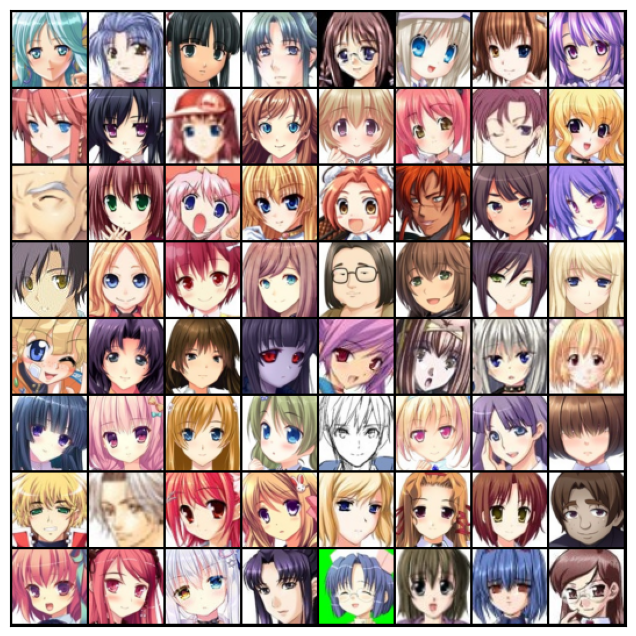

In [15]:
show_batch(train_dl)

In [16]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    return len(self.dl)


In [17]:
device=get_default_device()
device

device(type='cuda')

In [18]:
train_dl=DeviceDataLoader(train_dl,device)

In [19]:
import torch.nn as nn

In [24]:
discriminator=nn.Sequential(
              nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(64),
              nn.LeakyReLU(0.2,inplace=True),
              nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(128),
              nn.LeakyReLU(0.2,inplace=True),
              nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(256),
              nn.LeakyReLU(0.2,inplace=True),
              nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(512),
              nn.LeakyReLU(0.2,inplace=True),

              nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1, bias=False),
              nn.Flatten(),
              nn.Sigmoid()

)

In [25]:
discriminator=to_device(discriminator,device)

In [26]:
latent_size=128

In [27]:
generator=nn.Sequential(
              nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(512),
              nn.ReLU(True),
              nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(256),
              nn.ReLU(True),
              nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(128),
              nn.ReLU(True),
              nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(64),
              nn.ReLU(True),

              nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
              nn.Tanh(),

)

torch.Size([128, 3, 32, 32])


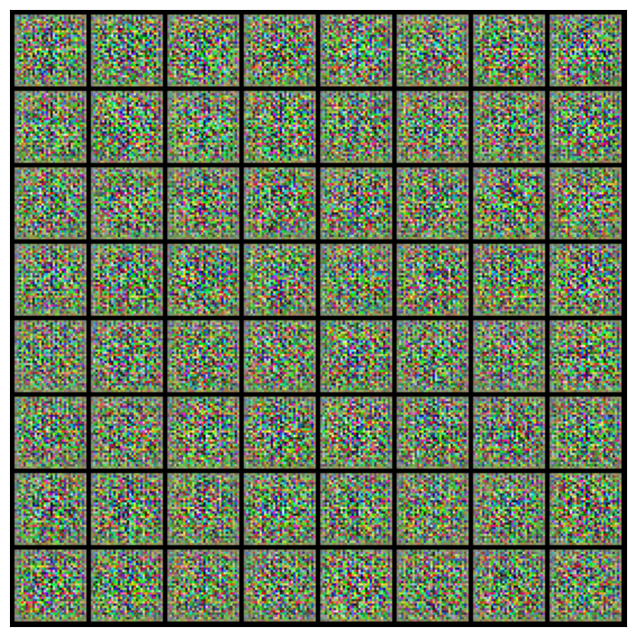

In [28]:
xb=torch.randn(batch_size,latent_size,1,1)
fake_images=generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [29]:
generator=to_device(generator,device)

In [ ]:
def train_discriminator(real_images,opt_d):
  opt_d.zero_grad()
